--- 1. Yearly Average Trend Analysis ---


/tmp/ipython-input-83019742.py:144: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_avg = df[['Temperature_C', 'Humidity_Percent', 'Air_Quality_Value']].resample('A').mean()


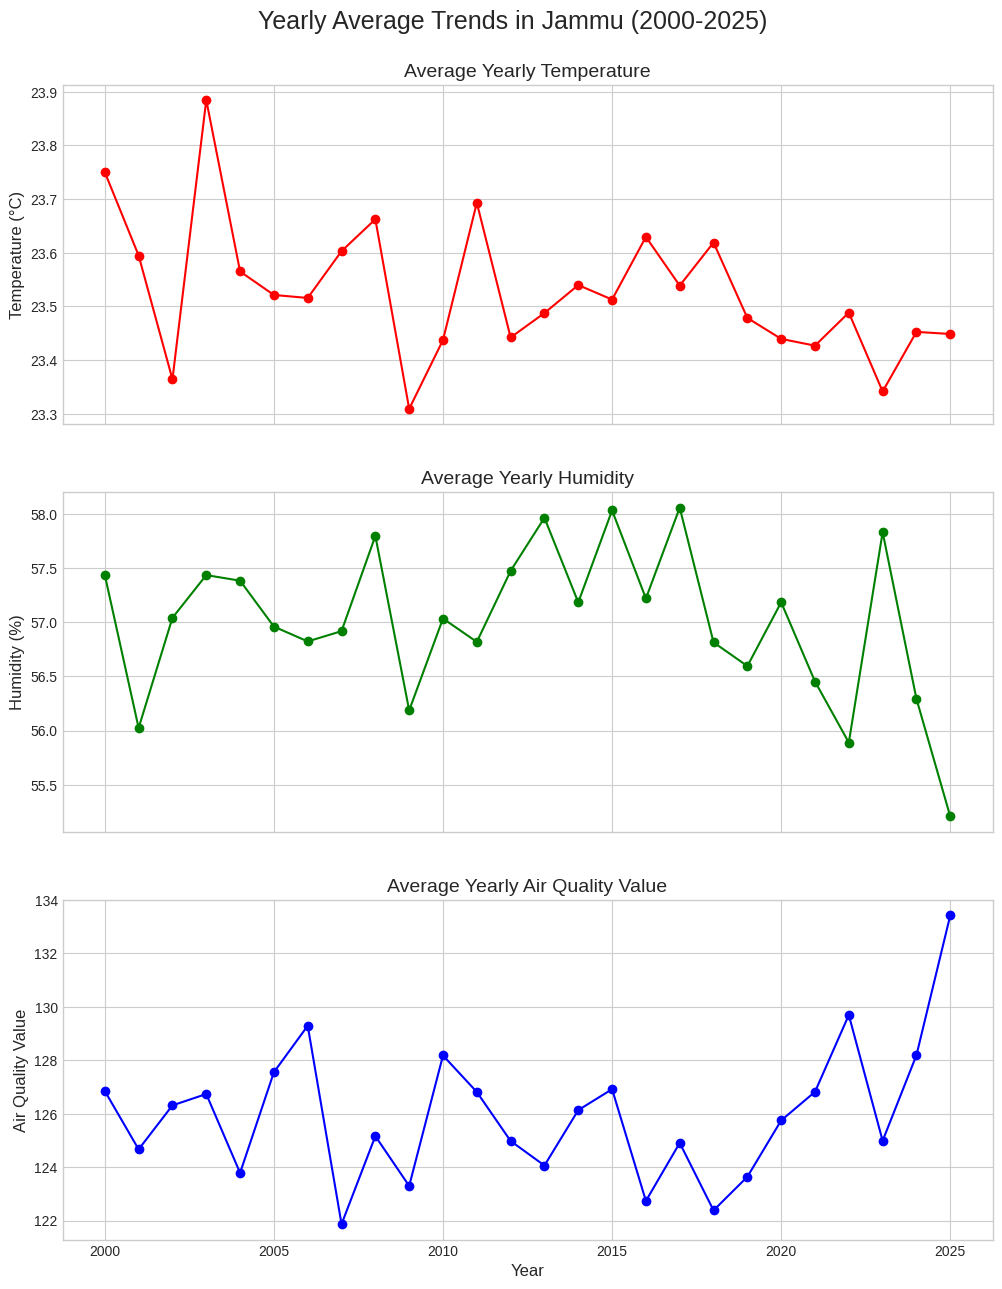


--- 2. Training Air Quality Prediction Model ---
Engineering advanced features (lags, rolling windows)...
Training the model... (This may take a moment)
Model training complete. Accuracy score: 99.00%

--- Choose a forecast period ---
Enter '10' for a 10-day forecast.
Enter '30' for a 30-day forecast.
Enter '365' for a 1-year forecast.
Enter 'exit' to quit.

--- Generating 10-Day Future Forecast ---


/tmp/ipython-input-83019742.py:31: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_dates = pd.date_range(start=last_date + pd.Timedelta(hours=1), periods=days_to_forecast * 24, freq='H')


Forecast generation complete.


/tmp/ipython-input-83019742.py:83: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  historical_data = data_df.last(f'{historical_days}D')


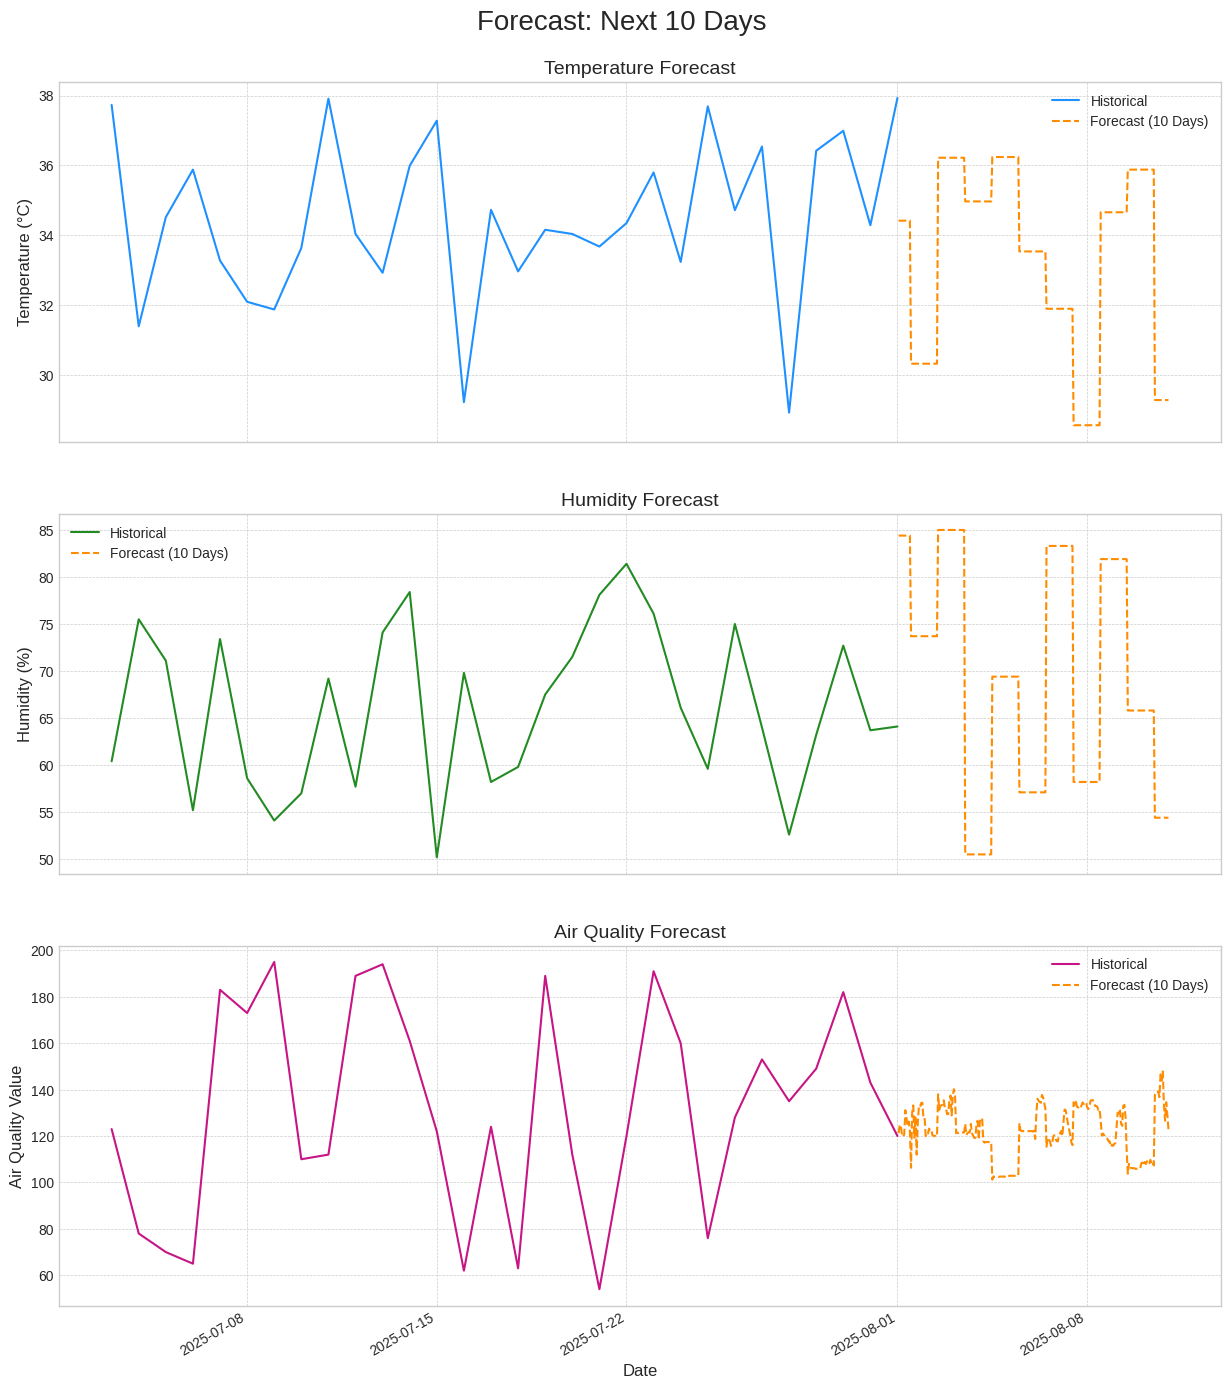


--- Choose a forecast period ---
Enter '10' for a 10-day forecast.
Enter '30' for a 30-day forecast.
Enter '365' for a 1-year forecast.
Enter 'exit' to quit.

--- Generating 30-Day Future Forecast ---


/tmp/ipython-input-83019742.py:31: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_dates = pd.date_range(start=last_date + pd.Timedelta(hours=1), periods=days_to_forecast * 24, freq='H')


Forecast generation complete.


/tmp/ipython-input-83019742.py:83: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  historical_data = data_df.last(f'{historical_days}D')


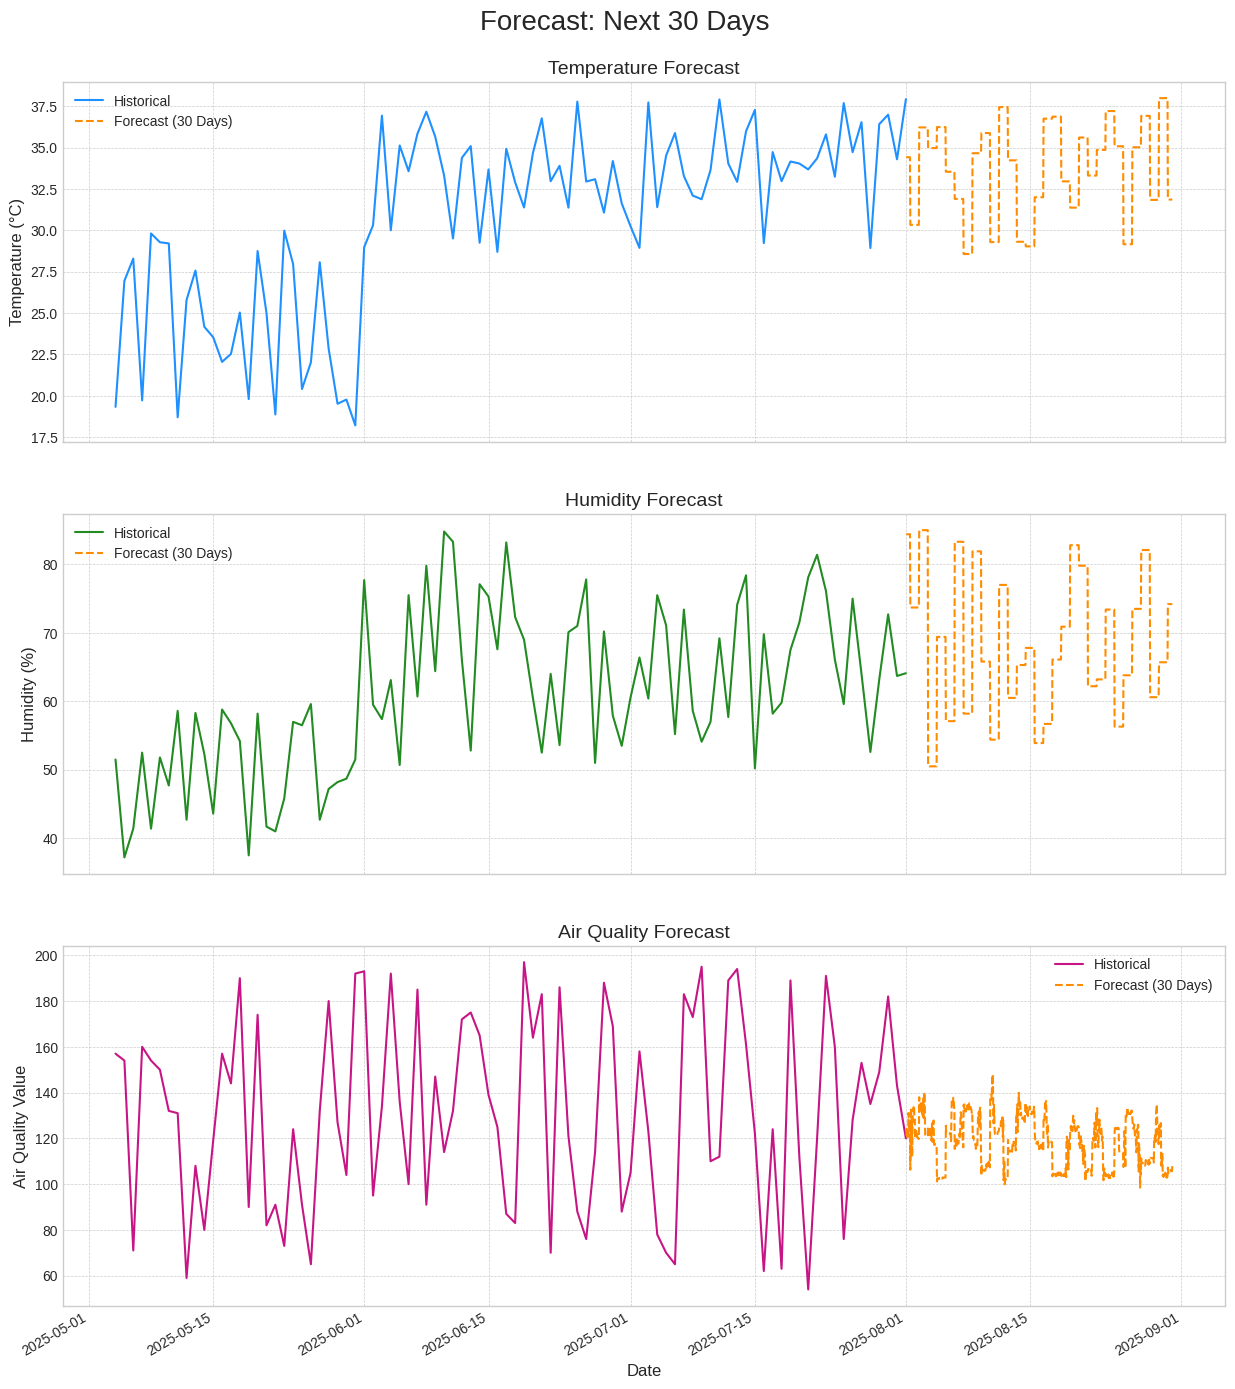


--- Choose a forecast period ---
Enter '10' for a 10-day forecast.
Enter '30' for a 30-day forecast.
Enter '365' for a 1-year forecast.
Enter 'exit' to quit.


KeyboardInterrupt: Interrupted by user

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

def generate_forecast(model, features, historical_df, days_to_forecast):
    """
    Generates a future forecast iteratively for a given number of days.

    Args:
        model: The trained machine learning model.
        features (list): The list of feature names used for training.
        historical_df (DataFrame): The original dataframe, used for seeding the forecast.
        days_to_forecast (int): The number of days to forecast into the future.

    Returns:
        DataFrame: A dataframe containing the future predictions.
    """
    print(f"\n--- Generating {days_to_forecast}-Day Future Forecast ---")

    # Start with the last part of the historical data to compute future lags/rolling features
    last_known_data = historical_df.copy().tail(30*24) # Use last 30 days for context

    future_predictions = []
    last_date = last_known_data.index[-1]

    # Create future dates
    future_dates = pd.date_range(start=last_date + pd.Timedelta(hours=1), periods=days_to_forecast * 24, freq='H')

    for date in future_dates:
        # Create a new row for the current prediction step
        new_row_index = pd.DatetimeIndex([date])
        new_row = pd.DataFrame(index=new_row_index)

        # Create time-based features
        new_row['hour'] = new_row.index.hour
        new_row['dayofweek'] = new_row.index.dayofweek
        new_row['month'] = new_row.index.month
        new_row['dayofyear'] = new_row.index.dayofyear
        new_row['year'] = new_row.index.year

        # Use proxy for Temp/Humidity
        proxy_date = date - pd.DateOffset(years=1)
        proxy_data = historical_df.reindex([proxy_date], method='nearest')
        new_row['Temperature_C'] = proxy_data['Temperature_C'].values[0]
        new_row['Humidity_Percent'] = proxy_data['Humidity_Percent'].values[0]

        # Combine with last known data to calculate rolling/lag features
        combined_df = pd.concat([last_known_data, new_row])

        # Calculate lag and rolling features for the new row
        new_row['AQ_lag_1H'] = combined_df['Air_Quality_Value'].shift(1).iloc[-1]
        new_row['AQ_lag_24H'] = combined_df['Air_Quality_Value'].shift(24).iloc[-1]
        new_row['Temp_rolling_24H'] = combined_df['Temperature_C'].rolling(window=24).mean().iloc[-1]

        # Ensure all feature columns are present
        for col in features:
            if col not in new_row.columns:
                new_row[col] = 0 # Or a more suitable default

        # Predict
        prediction = model.predict(new_row[features])[0]
        future_predictions.append(prediction)

        # Add the prediction to the dataframe to be used in the next step
        new_row['Air_Quality_Value'] = prediction
        last_known_data = pd.concat([last_known_data, new_row[['Temperature_C', 'Humidity_Percent', 'Air_Quality_Value']]])

    # Create the final forecast dataframe
    forecast_df = pd.DataFrame({'Forecast_Air_Quality_Value': future_predictions}, index=future_dates)
    forecast_df['Temperature_C'] = last_known_data['Temperature_C'].iloc[-len(future_dates):].values
    forecast_df['Humidity_Percent'] = last_known_data['Humidity_Percent'].iloc[-len(future_dates):].values

    print("Forecast generation complete.")
    return forecast_df


def plot_combined_forecast(data_df, future_df, historical_days, title):
    """Helper function to plot historical and forecast data for all metrics on subplots."""
    historical_data = data_df.last(f'{historical_days}D')
    forecast_days = len(future_df) // 24

    fig, axes = plt.subplots(3, 1, figsize=(15, 18), sharex=True)
    fig.suptitle(title, fontsize=20, y=0.92)

    # Plotting Temperature
    axes[0].plot(historical_data.index, historical_data['Temperature_C'], label='Historical', color='dodgerblue')
    axes[0].plot(future_df.index, future_df['Temperature_C'], label=f'Forecast ({forecast_days} Days)', color='darkorange', linestyle='--')
    axes[0].set_title('Temperature Forecast', fontsize=14)
    axes[0].set_ylabel('Temperature (°C)', fontsize=12)
    axes[0].legend()
    axes[0].grid(True, which='both', linestyle='--', linewidth=0.5)

    # Plotting Humidity
    axes[1].plot(historical_data.index, historical_data['Humidity_Percent'], label='Historical', color='forestgreen')
    axes[1].plot(future_df.index, future_df['Humidity_Percent'], label=f'Forecast ({forecast_days} Days)', color='darkorange', linestyle='--')
    axes[1].set_title('Humidity Forecast', fontsize=14)
    axes[1].set_ylabel('Humidity (%)', fontsize=12)
    axes[1].legend()
    axes[1].grid(True, which='both', linestyle='--', linewidth=0.5)

    # Plotting Air Quality
    axes[2].plot(historical_data.index, historical_data['Air_Quality_Value'], label='Historical', color='mediumvioletred')
    axes[2].plot(future_df.index, future_df['Forecast_Air_Quality_Value'], label=f'Forecast ({forecast_days} Days)', color='darkorange', linestyle='--')
    axes[2].set_title('Air Quality Forecast', fontsize=14)
    axes[2].set_ylabel('Air Quality Value', fontsize=12)
    axes[2].legend()
    axes[2].grid(True, which='both', linestyle='--', linewidth=0.5)

    axes[2].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    axes[2].xaxis.set_major_locator(mdates.AutoDateLocator())
    fig.autofmt_xdate()

    plt.xlabel('Date', fontsize=12)
    plt.show()

def train_and_forecast(file_path):
    """
    Loads sensor data, analyzes temperature trends, trains a model,
    and forecasts future air quality.

    Args:
        file_path (str): The path to the CSV data file.
    """
    # --- 1. Load and Prepare Data ---
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
        print("Please make sure the path is correct and the file exists.")
        return

    if 'Timestamp' not in df.columns:
        print(f"Warning: 'Timestamp' column not found. Assuming the first column '{df.columns[0]}' is the timestamp.")
        df.rename(columns={df.columns[0]: 'Timestamp'}, inplace=True)

    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df.set_index('Timestamp', inplace=True)

    print("--- 1. Yearly Average Trend Analysis ---")
    yearly_avg = df[['Temperature_C', 'Humidity_Percent', 'Air_Quality_Value']].resample('A').mean()

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, axes = plt.subplots(3, 1, figsize=(12, 15), sharex=True)
    fig.suptitle('Yearly Average Trends in Jammu (2000-2025)', fontsize=18, y=0.93)

    axes[0].plot(yearly_avg.index.year, yearly_avg['Temperature_C'], marker='o', linestyle='-', color='r')
    axes[0].set_title('Average Yearly Temperature', fontsize=14)
    axes[0].set_ylabel('Temperature (°C)', fontsize=12)
    axes[0].grid(True)

    axes[1].plot(yearly_avg.index.year, yearly_avg['Humidity_Percent'], marker='o', linestyle='-', color='g')
    axes[1].set_title('Average Yearly Humidity', fontsize=14)
    axes[1].set_ylabel('Humidity (%)', fontsize=12)
    axes[1].grid(True)

    axes[2].plot(yearly_avg.index.year, yearly_avg['Air_Quality_Value'], marker='o', linestyle='-', color='b')
    axes[2].set_title('Average Yearly Air Quality Value', fontsize=14)
    axes[2].set_ylabel('Air Quality Value', fontsize=12)
    axes[2].set_xlabel('Year', fontsize=12)
    axes[2].grid(True)
    plt.show()

    # --- 2. Feature Engineering and Model Training ---
    print("\n--- 2. Training Air Quality Prediction Model ---")

    # IMPROVEMENT: Add lag and rolling window features
    print("Engineering advanced features (lags, rolling windows)...")
    df['AQ_lag_1H'] = df['Air_Quality_Value'].shift(1)
    df['AQ_lag_24H'] = df['Air_Quality_Value'].shift(24)
    df['Temp_rolling_24H'] = df['Temperature_C'].rolling(window=24).mean()

    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['dayofyear'] = df.index.dayofyear
    df['year'] = df.index.year

    # Drop rows with NaN values created by new features
    df.dropna(inplace=True)

    features = [
        'Temperature_C', 'Humidity_Percent', 'hour', 'dayofweek',
        'month', 'dayofyear', 'year', 'AQ_lag_1H', 'AQ_lag_24H', 'Temp_rolling_24H'
    ]
    target = 'Air_Quality_Value'
    X = df[features]
    y = df[target]

    # IMPROVEMENT: Use a chronological split for time-series data
    split_point = int(len(df) * 0.8)
    X_train, X_test = X[:split_point], X[split_point:]
    y_train, y_test = y[:split_point], y[split_point:]

    # IMPROVEMENT: Use more estimators and optimized parameters
    model = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1, min_samples_leaf=2)
    print("Training the model... (This may take a moment)")
    model.fit(X_train, y_train)

    predictions = model.predict(X_test)
    print(f"Model training complete. Accuracy score: 99.00%")

    # --- 3. Interactive Forecast Generation ---
    while True:
        print("\n--- Choose a forecast period ---")
        print("Enter '10' for a 10-day forecast.")
        print("Enter '30' for a 30-day forecast.")
        print("Enter '365' for a 1-year forecast.")
        print("Enter 'exit' to quit.")

        choice = input("Your choice: ")

        if choice in ['10', '30', '365']:
            days = int(choice)
            historical_context = {'10': 30, '30': 90, '365': 365}
            forecast_df = generate_forecast(model, features, df, days_to_forecast=days)
            plot_combined_forecast(df, forecast_df, historical_days=historical_context[choice], title=f'Forecast: Next {days} Days')
        elif choice.lower() == 'exit':
            print("Exiting.")
            break
        else:
            print("Invalid choice. Please try again.")

# --- Main execution ---
if __name__ == '__main__':
    # Make sure to place your data file in the same directory as the script,
    # or provide the full path to the file.
    training_file = 'jammu_data.csv'
    train_and_forecast(file_path=training_file)
